In [1]:
import numpy as np
import numpy.random as np_rand
import scipy.special as sc
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from scipy.io import arff
from numpy.lib.recfunctions import structured_to_unstructured
from timeit import default_timer


## Simulated data

In [2]:
# Define parameters
k = 20 # truncation level for truncated drichlet process
alpha = 5 # concentration parameter for DP
n_samples = 100 # Number of X sample points to generate
num_of_gaussian_dim = 2 # Number of dimensions in Gaussian distribution from which X will be sampled
rho = 0.8 # first-order autocorrelation coefficient for covariance matrix of Gaussian distribution from which X will be sampled
variance_prior = 100 # variance of Gaussian baseline distribution in DP
variance_sample = 4 # variance of the gaussion from which X will be sampled


In [3]:
# Generate the baseline 2-dim Gaussion distribution prior of DP
base_mean = np.zeros(num_of_gaussian_dim) # zero-mean Gaussian
base_cov = np.eye(num_of_gaussian_dim) * variance_prior # scaled for comparison across dimensions (values should be of similar order)

#base_cov = [[100, 0], [0, 100]]
print("base_mean: \n", base_mean)
print("base_cov: \n", base_cov)

base_mean: 
 [0. 0.]
base_cov: 
 [[100.   0.]
 [  0. 100.]]


In [4]:
# Generate eta from baseline distribution of DP (Unique values of means(each per dim) from the 2-dim gaussion prior distribution of DP)
eta_params = np_rand.multivariate_normal(base_mean, base_cov, size=k)
#means = norm.rvs(base_mean, base_cov) # draw normal random variables for means
print("eta_params:\n", eta_params)

eta_params:
 [[ -4.88837267  13.65940641]
 [-11.25129889   5.94205074]
 [ 11.73190287 -12.29949848]
 [ -5.9066485   19.58885566]
 [ -5.69283163   0.14147633]
 [  1.17352794   0.95327427]
 [ -4.85820303 -10.59274336]
 [  0.02956944   6.58899997]
 [  8.45467642   2.25265903]
 [  3.73918339   6.06609637]
 [ 12.55508583   2.58007426]
 [ 12.83369631 -16.70577203]
 [ -7.33403388  -0.49195861]
 [ -4.59447801   0.57327458]
 [ -4.2209741   15.51688294]
 [ -1.10001841  -3.99023324]
 [ -2.61019724  -8.04894466]
 [ -5.83710539 -18.77773306]
 [ 11.04272044  -9.513552  ]
 [ -6.57062625  10.50901816]]


In [5]:
# DP using stick-breaking technique
V_params = np_rand.beta(1, alpha, size=k)
V_params[k-2] = 1 #Truncate DP construction at K by setting V_K-1 = 1, but in our case k index start from 0
print("V_params:\n ", V_params)

theta_params = np.zeros(k) # initialize the theta_params
remaining_stick = 1 # initialize the remaining stick length
for i in range(k):
    theta_params[i] = V_params[i] * remaining_stick # break the stick
    remaining_stick *= (1 - V_params[i]) # update the remaining stick length
print("theta_params:\n ", theta_params)

V_params:
  [0.03787291 0.1176055  0.06089157 0.29134162 0.2605995  0.12164391
 0.07100397 0.27647156 0.21768215 0.05675731 0.08893059 0.01664232
 0.20822257 0.20994279 0.09573273 0.56365703 0.04749724 0.30652949
 1.         0.11486364]
theta_params:
  [0.03787291 0.11315143 0.05169546 0.2322809  0.14723854 0.05081805
 0.02605439 0.09424592 0.05368965 0.01095148 0.01618548 0.00275956
 0.03395199 0.0271045  0.00976471 0.05198892 0.00191158 0.01175066
 0.02658386 0.        ]


In [6]:
# Generate the first-order autocorrelation fixed covariance matrix of Gaussian distribution from which X will be sampled
cov = np.zeros((num_of_gaussian_dim, num_of_gaussian_dim)) # initialize the covariance matrix
for i in range(num_of_gaussian_dim):
    for j in range(num_of_gaussian_dim):
            cov[i, j] = variance_sample*(rho ** abs(i - j)) # assign the value based on the distance

#cov = [[3, 0.95], [0.95, 3]]
print('cov matrix: \n', cov)

cov matrix: 
 [[4.  3.2]
 [3.2 4. ]]


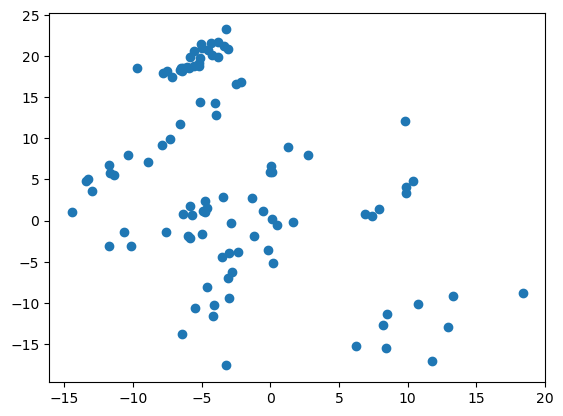

In [7]:
# Generate the samples from the Gaussion-Gaussion distribution
samples = np.zeros((n_samples, num_of_gaussian_dim)) # initialize the data matrix
z_params = np.zeros(n_samples, dtype=int) # initilize the z parameter

for i in range(n_samples):
    z_params[i] = np_rand.choice(k, p=theta_params) # assign a cluster to each sample point
    samples[i] = np_rand.multivariate_normal(eta_params[z_params[i]], cov) # draw a Sample point from the assigned cluster

# print("Samples: \n", samples)
plt.scatter(samples[:,0],samples[:,1])

In [8]:
import itertools
import matplotlib as mpl
from scipy import linalg

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, title):
    """
    Plot gaussian components as ellipses
    """
    splot = plt.subplot(1, 1, 1)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        # covar = np.diag(covar)
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.title(title)

In [9]:
# The scipy BGM do not provide a variance-fixed gaussian component option. 
bgm = BayesianGaussianMixture(n_components=k, weight_concentration_prior=None, n_init=1, covariance_type="full", max_iter=1000, verbose=2)
bgm.fit(samples)

Initialization 0
  Iteration 10	 time lapse 0.09200s	 ll change 1.51269
  Iteration 20	 time lapse 0.01901s	 ll change 0.13329
  Iteration 30	 time lapse 0.01699s	 ll change 0.00400
Initialization converged: True	 time lapse 0.13899s	 ll -598.77568


BayesianGaussianMixture(max_iter=1000, n_components=20, verbose=2)

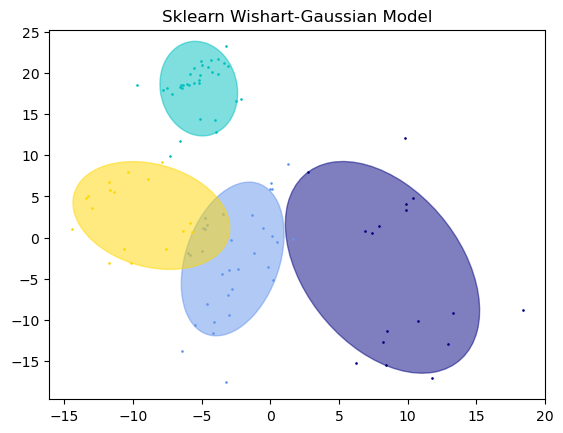

In [10]:
plot_results(samples, bgm.predict(samples), bgm.means_, bgm.covariances_, "Sklearn Wishart-Gaussian Model")

### Spherical covariance model

In [11]:
from scipy.special import logsumexp

M = 51

def plot_contour(model, x, x_min, x_max, y_min, y_max):
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, M), np.linspace(y_min, y_max, M))
    
    xy = np.stack((xv, yv), axis=-1).reshape((M * M, 2))
    prob = logsumexp(model.predict(xy), axis=1)
    z = np.reshape(prob, (M, M))

    plt.figure()
    plt.scatter(x[:, 0], x[:, 1], 0.8)
    plt.contour(xv, yv, z)
    plt.show()
    

Converge at iter 87
ELBO = -789.00482282514


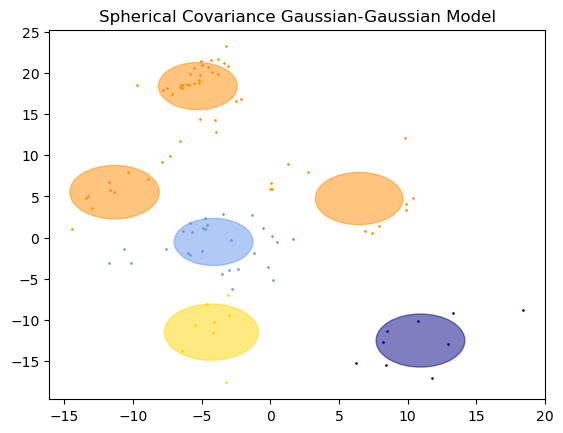

In [12]:
# Our model assume a fixed covariance in each component
from dp import *

eps = 1e-3
var_samples = np.var(samples, axis=0)
mu_samples = np.mean(samples, axis=0)

# Initialization
sigma0 = (np.prod(var_samples) ** 0.5) # Variance on each dimension, in each component
sigma = sigma0 / k # Baseline variance, on each dimension
dp = DpGaussianSpherical(samples, alpha=1e0, sigma=sigma, mu0=mu_samples, sigma0=sigma0, K=k)

elbo = - np.inf

# CAVI update
for i in range(1000):
    prev_elbo = elbo
    dp.update()
    elbo = dp.elbo()
    if abs(elbo - prev_elbo) < eps:
        print("Converge at iter", i)
        break

print("ELBO =", elbo)
prob = dp.predict(samples)
label = np.argmax(prob, axis=1)

sigma_x = np.zeros((k, 2, 2))
for i in range(k):
    sigma_x[i] = np.identity(2) * (dp.sigma + dp.sigma_p[i])

plot_results(samples, label, dp.mu_p, sigma_x, "Spherical Covariance Gaussian-Gaussian Model")

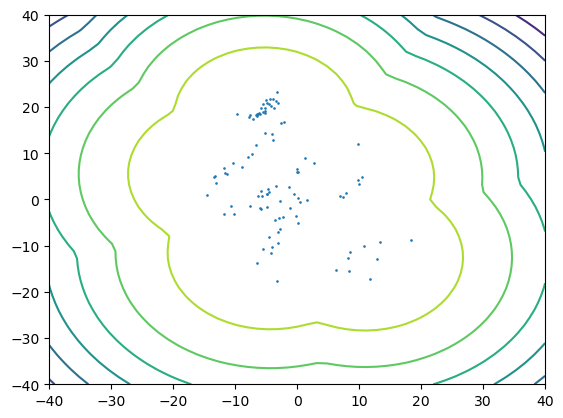

In [13]:
plot_contour(dp, samples, -40, 40, -40, 40)

### Full covariance model

Converge at iter 65
ELBO = -1117.6840553214652


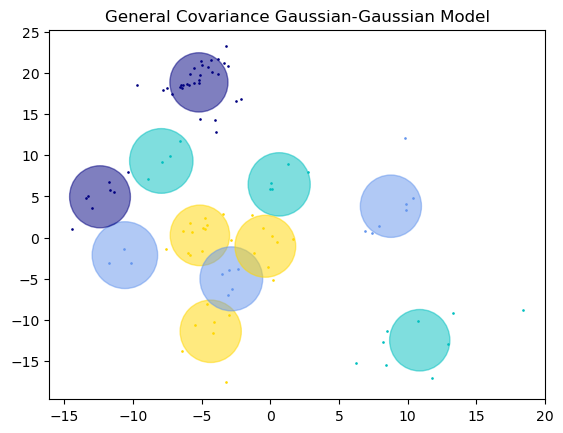

In [14]:

# Initialization
cov_samples = np.cov(samples.T)
Sigma = np.diag(var_samples) / k # Covariance matrix of each component
Sigma0 = cov_samples # Baseline covariance
dp = DpGaussianFull(samples, alpha=1e0, Sigma=Sigma, mu0=mu_samples, Sigma0=Sigma0, K=k)

elbo = - np.inf

# CAVI update
for i in range(1000):
    prev_elbo = elbo
    dp.update()
    elbo = dp.elbo()
    if abs(elbo - prev_elbo) < eps:
        print("Converge at iter", i)
        break

print("ELBO =", elbo)
prob = dp.predict(samples)
label = np.argmax(prob, axis=1)
plot_results(samples, label, dp.mu_p, dp.Sigma + dp.Sigma_p, "General Covariance Gaussian-Gaussian Model")

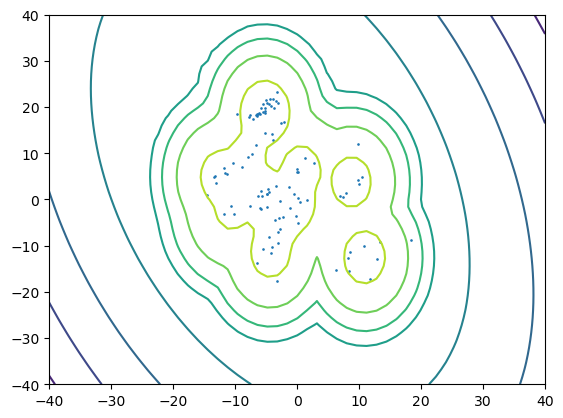

In [15]:
plot_contour(dp, samples, -40, 40, -40, 40)